In [2]:
import numpy as np
from vorothreshold import voronoi_threshold_finder
from vorothreshold.read_funcs import read_voronoi_vide
import matplotlib.pyplot as plt

The standard methodology to postprocess vide voids in lightconse in order to find the corresponding threshold voids, requires a few quantities, which are:

- A list/array or a single value of thredholds. This should be passed as the value of the normalized density, i.e. 1+$\delta$

- The array of the density corresponding to each thracer

- The path of vide directory, the one containing all the outputs 

- A range in which consider voids to be analyzed. Thi can be passed eithr as a comoving distance, or redshift range.

- Cosmological parameters to convert redshift in distance. If the cosmological model is LCDM, then $\Omega_{\rm m}$ is enough (other parameters are $w_0$ and $w_{\rm a}$)

The path to VIDE output and $\Omega_{\rm m}$ are:

In [3]:
vide_path='data/lightcone/examples/example_observation/sample_example_observation/'
OmegaM = 0.3

In the following code cell, we measure the mean number density at the position of each galaxy. To do so we measure the number density of galaxise as a function of redshift, an then assigne the corresmonding mean density to each galaxy. 

In this example we use the galaxy catalog is stored in the VIDE output, we load it with the function `read_voronoi_vide`, which wants in input the path of VIDE output directory and the sample_name. This function gives in output the ID of tracers (`ids_voro`) (which is the same of Voronoi cells), the corresponding Voronoi volumes (`VoroVol`), cartesian coordinate as computed by VIDE (`VoroXYZ`, note that these are translated by vide to fit in a box, so they are not physical coordinates), finally the physical RA, Dec, redshift (`RA`, `Dec`, `redshift`).

In [4]:

sample_name = 'example_observation'
ids_voro, VoroVol, VoroXYZ, RA, Dec, redshift = read_voronoi_vide(vide_path,sample_name)


To compute the number density as a function of the redshift we need the solid angle of the survey. We compute it by loading the healpy mask used by VIDE.

In that case the galaxy number density is approximately constant, in general it should be fitted on interpolated.

The comoving range `comov_range`, will be used to avoid to have voids touching the bourder (voids that have voronicell crossing this boundary after the threshold procedure, will not be considered).

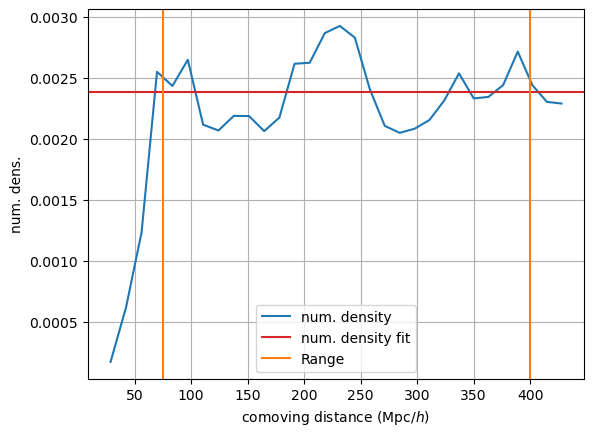

In [5]:
from vorothreshold.utilities import ComovingDistanceOverh
import healpy as hp

mask_gal_file = vide_path + 'mask_map.fits'
mask = hp.read_map(mask_gal_file)
sky_frac = np.sum(mask)/mask.shape[0]

w0=-1.
wa=0.
dist_z = ComovingDistanceOverh(OmegaM,w0,wa)
hist_z, z_bins = np.histogram(redshift,bins=31)

comov_bins = dist_z.get_dist(z_bins)
comov3 = dist_z.get_dist(z_bins)**3
shell_vol = 4*np.pi/3.*sky_frac*(comov3[1:] - comov3[:-1])
z_mean = 0.5 * (z_bins[1:] + z_bins[:-1])
dist_mean = dist_z.get_dist(z_mean)
comov_range = (75,400)
mean_dens = np.mean((hist_z/shell_vol)[(dist_mean>=comov_range[0]) & (dist_mean<=comov_range[1])])
plt.plot(dist_mean,hist_z/shell_vol,label='num. density')
plt.axhline(mean_dens,label='num. density fit',c=plt.cm.tab10(3))
plt.axvline(comov_range[0],label='Range',c=plt.cm.tab10(1))
plt.axvline(comov_range[1],c=plt.cm.tab10(1))
plt.legend()
plt.ylabel('num. dens.')
plt.xlabel('comoving distance (Mpc/$h$)')
plt.grid()

zDens = np.full(redshift.shape[0],mean_dens)

The computation are performed when inizializing the `voronoi_threshold_finder` class, passing as arguments the ones listed above. The `thresholds` list can be contain various values, we chose a single value as an example.

In [6]:

thresholds = [0.3]

th_voids = voronoi_threshold_finder(thresholds,lightcone=True,tracer_dens=zDens,vide_path=vide_path,comov_range=comov_range,OmegaM=OmegaM,w0=w0,wa=w0,verbose=True)


max_num_part < 0: authomatically set to 5 * max(num_part): 3685

    voronoi_threshold started

    nthreads set to 32

    max_num_part set to 3685

    computation started


/mnt/home/gverza/python_venv/base/lib/python3.10/site-packages/vorothreshold/voronoi_threshold.py:306: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  ID_voro_dict[iv],ID_core_arr[iv],max_num_part,neighbor_ptr,neighbor_ids,Nthresholds,threshold_arr,VoroXYZ,VoroVol,zDens)


    done, 0 h 0 min 10.872230768203735 sec. 



In [8]:
max_voro_in_voids = np.max(th_voids.get_values(np.max(thresholds),'Ncells',1.))
max_voro_in_voids = int(max_voro_in_voids) + int(max_voro_in_voids%1 > 0)
print('max_num_part passed:',th_voids.max_num_part,'max num of voronoi in one void:',max_voro_in_voids)

max_num_part passed: 3685 max num of voronoi in one void: 22


To get the output we use the `get_values` function of the `voronoi_threshold_finder` class. The arguments are the threshold value, among the values in `thresholds`, the quantity we want to obtain, and the overlapping fraction,`frac_ovlp`. This last quantity is a free parameter, any value below oer equal to 0.5 are fine. The output will contains voids which overlaps for a fraction of their volume minor or equal to  `frac_ovlp`. This quantity in quite important to avoid double counting, as the thresholding procedure may merge adjacent basins.

In [9]:
xyz = dict()
radius = dict()
z_voids = dict()
frac_ovlp = 0.25
for thr in thresholds:
    xyz[thr] = dict()
    radius[thr] = dict()
    z_voids[thr] = dict()
    xyz[thr][frac_ovlp] = th_voids.get_values(thr,'xyz',frac_ovlp)
    radius[thr][frac_ovlp] = th_voids.get_values(thr,'radius',frac_ovlp)
    z_voids[thr][frac_ovlp] = th_voids.get_values(thr,'redshift',frac_ovlp)
    #print(xyz[thr][frac_ovlp].shape,radius[thr][frac_ovlp].shape,z_voids[thr][frac_ovlp].shape)


overlapping_fraction started.

    nthreads set to 1

    R_max computed. Max val = 33.03931735158822

    Lbox not passed, using xyz_vds as reference:
    min(xyz_vds) = -293.671615532162 -344.81554962201744 13.346109192462851
    max(xyz_vds) = 240.20022230456877 -105.56012683939583 344.11546187024476
    Lbox = 533.8718378367307

    ngrid not passed. Set to optimal value: 16

    order_ids_tracers_selected_in_voxels started
    done, 0 h 0 min 0.4317178726196289 sec.

    computation started (periodic-boundaries condition off)
    done, 0 h 0 min 1.4304487705230713 sec. 



1.0 (25, 3) (25,) (25,)
0.5 (25, 3) (25,) (25,)
0.25 (25, 3) (25,) (25,)
0.1 (24, 3) (24,) (24,)
0.0 (24, 3) (24,) (24,)
(214, 1) (452,)


Text(0.5, 0, 'z [Mpc/$h$]')

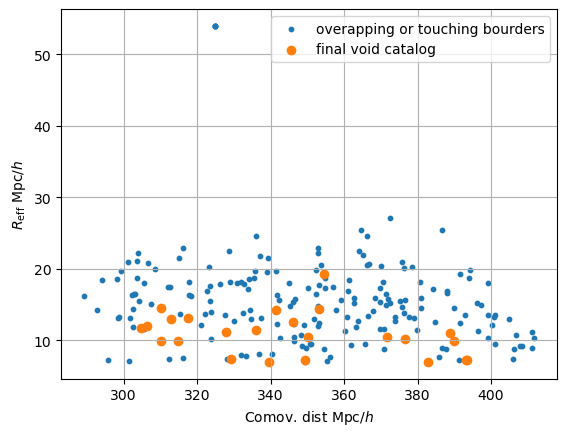

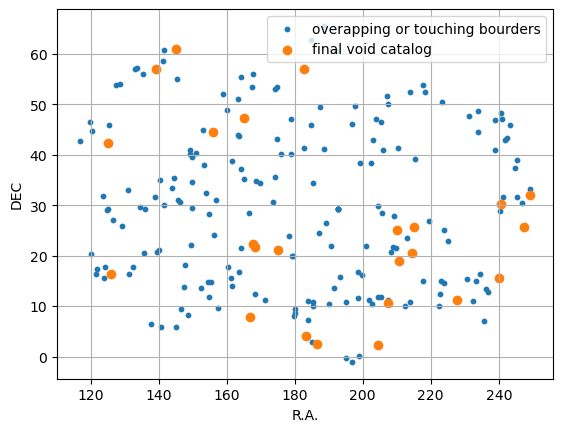

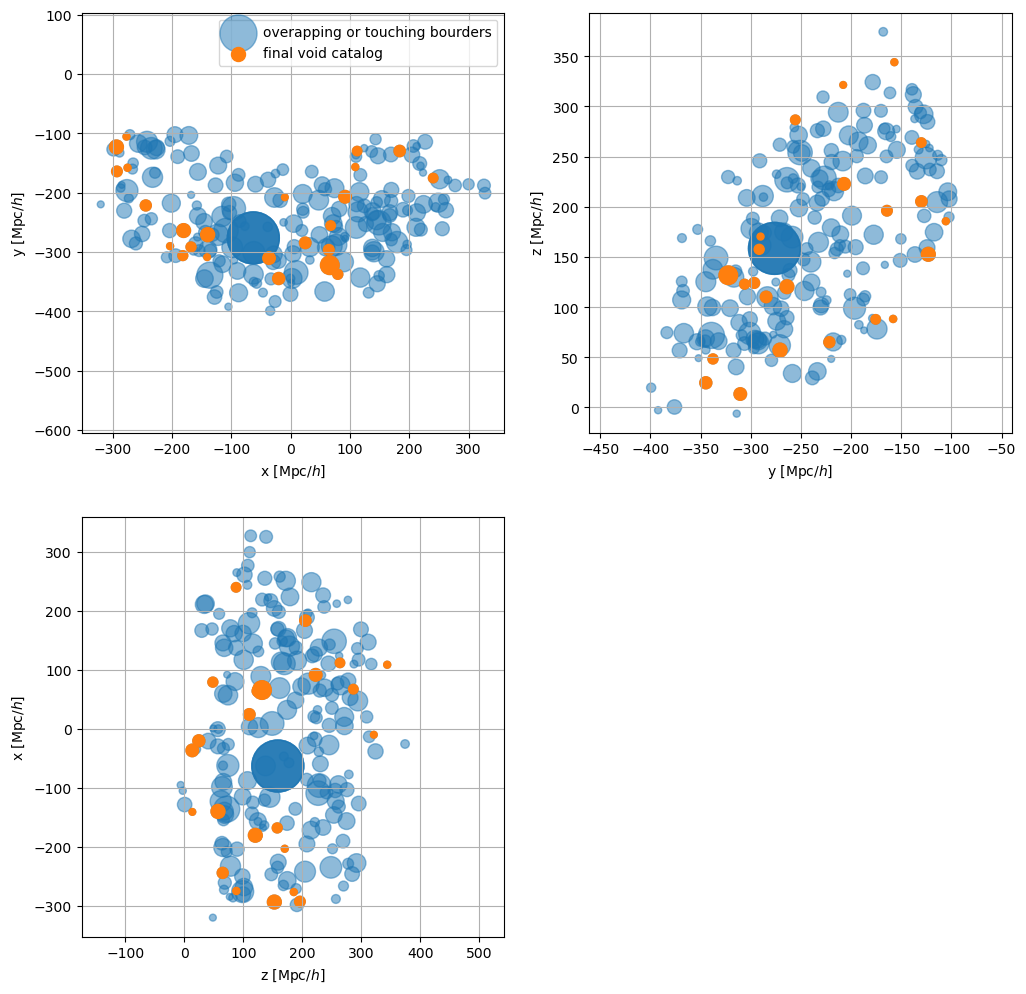

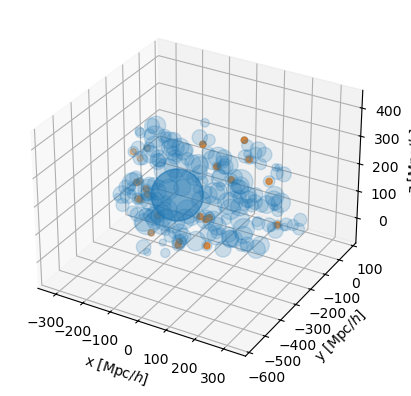

In [11]:
from vorothreshold.utilities import from_XYZ_to_rRAdec
from vorothreshold.read_funcs import vide_voids_cat
thr = 0.3
ith = 0
comov_dist = dict()
RA = dict()
DEC = dict()
volume = dict()
for frac_ovlp in [1.,0.5,0.25,0.1,0.]:
    comov_dist[thr] = dict()
    RA[thr] = dict()
    DEC[thr] = dict()
    volume[thr] = dict()
    
    xyz[thr][frac_ovlp] = th_voids.get_values(thr,'xyz',frac_ovlp)
    radius[thr][frac_ovlp] = th_voids.get_values(thr,'radius',frac_ovlp)
    volume[thr][frac_ovlp] = th_voids.get_values(thr,'volume',frac_ovlp)
    RA[thr][frac_ovlp] = th_voids.get_values(thr,'RA',frac_ovlp)
    DEC[thr][frac_ovlp] = th_voids.get_values(thr,'DEC',frac_ovlp)
    z_voids[thr][frac_ovlp] = th_voids.get_values(thr,'redshift',frac_ovlp)
    comov_dist[thr][frac_ovlp] = np.sum(xyz[thr][frac_ovlp]**2,axis=1)**0.5 #th_voids.get_values(thr,'comov_dist',frac_ovlp)
    print(frac_ovlp,xyz[thr][frac_ovlp].shape,radius[thr][frac_ovlp].shape,z_voids[thr][frac_ovlp].shape)
dist_all, RA_all, DEC_all = from_XYZ_to_rRAdec(th_voids.Xcm[:,ith,0],th_voids.Xcm[:,ith,1],th_voids.Xcm[:,ith,2])

barycenter,Reff_vide,redshift_vds,voidID,RAvide,DEC_vide,coreID,core_dens,core_pos,RAcore,DECcore,redshift_core = vide_voids_cat(vide_path,'example_observation',
    values_out=['barycenter','radius','redshift','voidID','RA','DEC','core_ID','core_dens','core_pos','RAcore','DECcore','redshift_core'],as_dict=False)
fig = plt.figure()
#plt.scatter(dist_z.get_dist(redshift_vds),Reff_vide)
plt.scatter(dist_all,(th_voids.Vol_interp[:,ith]* 3. / (4. * np.pi)) ** (1./3.),label='overapping or touching bourders',s=10)
plt.scatter(comov_dist[thr][frac_ovlp],radius[thr][frac_ovlp],label='final void catalog')#,s=5)
#plt.axvline(comov_range[0])
#plt.axvline(comov_range[1])
#plt.xlim(250,450)
#print(np.argmax(th_voids.Vol_interp[:,0]),np.max(th_voids.Vol_interp[:,0]))
plt.legend()
plt.grid()
plt.xlabel('Comov. dist Mpc/$h$')
plt.ylabel('$R_{\\rm eff}$ Mpc/$h$')

fig = plt.figure()
plt.scatter(RA_all,DEC_all,label='overapping or touching bourders',s=10)
plt.scatter(RA[thr][frac_ovlp]%360,DEC[thr][frac_ovlp],label='final void catalog')#,s=5)
plt.legend()
plt.grid()
plt.xlabel('R.A.')
plt.ylabel('DEC')


print(th_voids.Vol_interp.shape,Reff_vide.shape)


fig = plt.figure(figsize=(12,12))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
    ax[i].scatter(th_voids.Xcm[:,ith,i%3],th_voids.Xcm[:,ith,(i+1)%3],s=(th_voids.Vol_interp[:,ith]* 3. / (4. * np.pi)/3) ** (2./3.),alpha=0.5,label='overapping or touching bourders')
    ax[i].scatter(xyz[thr][frac_ovlp][:,i%3],xyz[thr][frac_ovlp][:,(i+1)%3],s=(volume[thr][frac_ovlp]* 3. / (4. * np.pi)/3) ** (2./3.),label='final void catalog')
    ax[i].axis('equal')
    ax[i].grid()
    ax[i].set_xlabel(['x','y','z'][i%3]+' [Mpc/$h$]')
    ax[i].set_ylabel(['x','y','z'][(i+1)%3]+' [Mpc/$h]$')
ax[0].legend()


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(th_voids.Xcm[:,ith,0],th_voids.Xcm[:,ith,1],th_voids.Xcm[:,ith,2],s=(th_voids.Vol_interp[:,ith]* 3. / (4. * np.pi)/3) ** (2./3.),alpha=0.2)
ax.scatter(xyz[thr][frac_ovlp][:,0],xyz[thr][frac_ovlp][:,1],xyz[thr][frac_ovlp][:,2])
ax.axis('equal')
ax.set_xlabel('x [Mpc/$h$]')
ax.set_ylabel('y [Mpc/$h$]')
ax.set_zlabel('z [Mpc/$h$]')

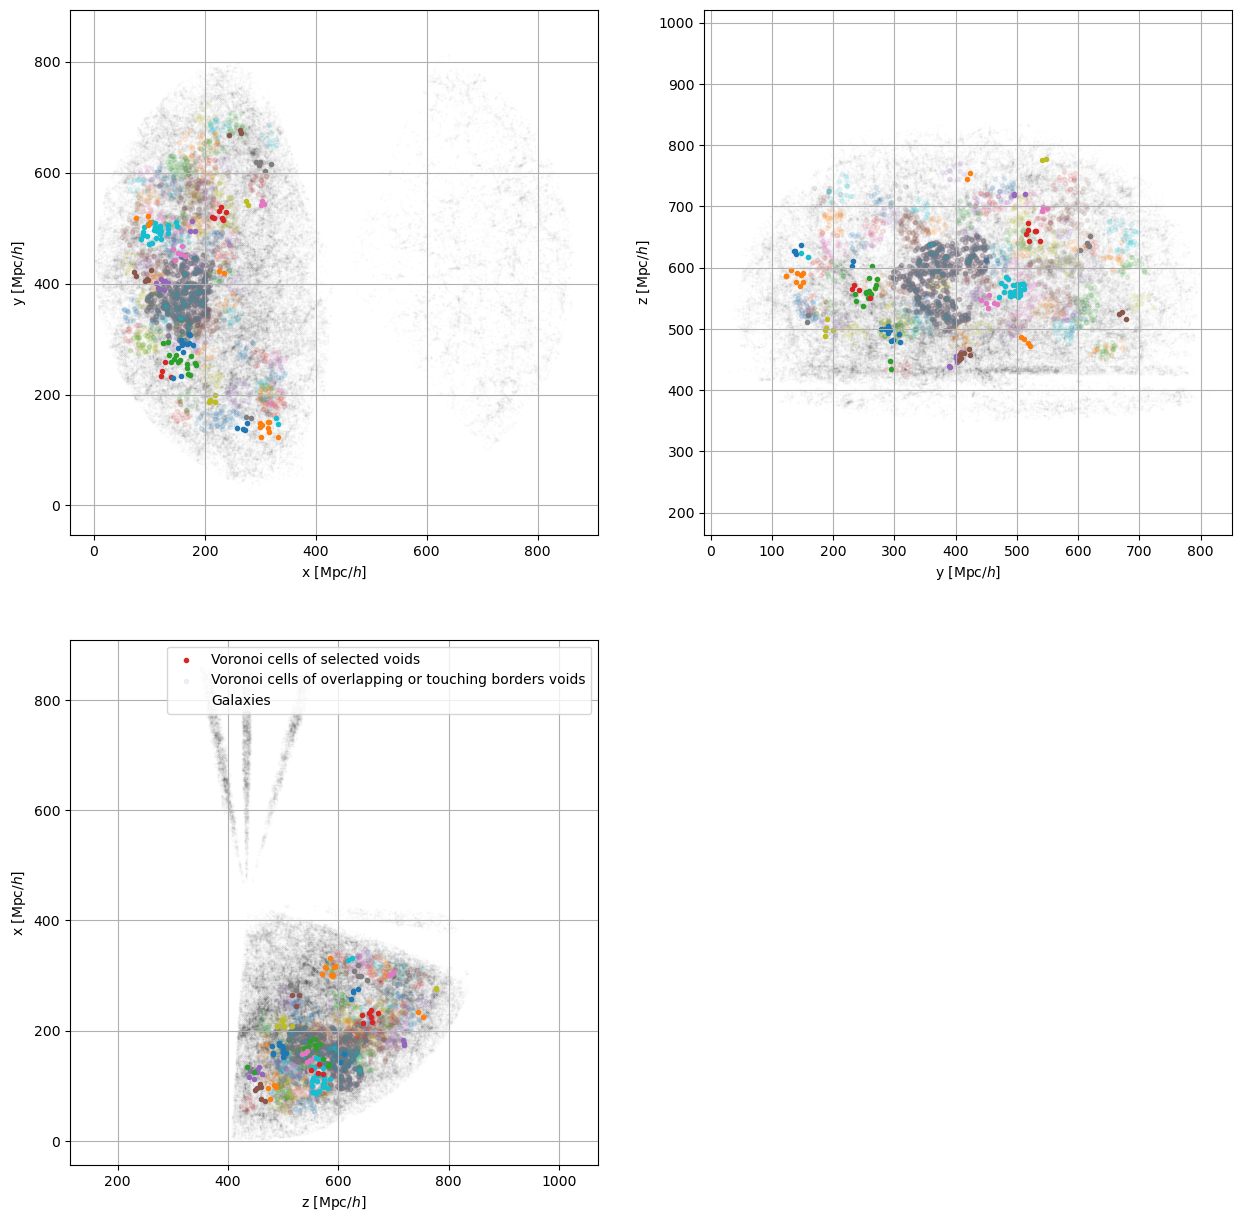

In [16]:
#from vorothreshold.read_funcs import read_voronoi_vide
#asd = voro_in_vide_voids('data/lightcone/examples/example_observation/sample_example_observation/','example_observation')

id_selected = np.arange(th_voids.Xcm.shape[0])[th_voids.Ncells_in_void[:,0] > 10]
id_ovlp_out = th_voids.get_values(thr,'id_selected',frac_ovlp)
fig = plt.figure(figsize=(15,15))
ax = dict()
for i in range(3):
    ax[i] = plt.subplot2grid((2,2), (int(i/2),i%2), rowspan=1, colspan=1)
    ax[i].scatter(VoroXYZ[:,i%3],VoroXYZ[:,(i+1)%3],s=0.1,alpha=0.02,c='k')
progr = 0
for id in id_selected:
    Xcm_interp = th_voids.Xcm[id,0,:]
    IDthresholds = th_voids.ID_voro_dict[id][:int(th_voids.Ncells_in_void[id,0]+1)]
    alpha = 0.1
    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=9,alpha=0.1)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    progr +=1
progr = 0
for id in id_ovlp_out:
    Xcm_interp = th_voids.Xcm[id,0,:]
    IDthresholds = th_voids.ID_voro_dict[id][:int(th_voids.Ncells_in_void[id,0]+1)]
    
    for i in range(3):
        ax[i].scatter(VoroXYZ[IDthresholds,i%3],VoroXYZ[IDthresholds,(i+1)%3],s=9,alpha=1.)
            #ax[i].scatter(Xcm_interp[i%3],Xcm_interp[(i+1)%3])
        #ax[i].scatter(core_pos[iv,i%3],core_pos[iv,(i+1)%3],c='r',)
        #ax[i].scatter(barycenter[iv,i%3],barycenter[iv,(i+1)%3],c='m')
    progr +=1
for i in range(3):
    ax[i].axis('equal')
    ax[i].set_xlabel(['x','y','z'][i%3]+' [Mpc/$h$]')
    ax[i].set_ylabel(['x','y','z'][(i+1)%3]+' [Mpc/$h$]')
    ax[i].grid()
ax[2].scatter(np.nan,np.nan,s=9,alpha=1.,label='Voronoi cells of selected voids')
ax[2].scatter(np.nan,np.nan,s=9,alpha=0.1,label='Voronoi cells of overlapping or touching borders voids')
ax[2].scatter(np.nan,np.nan,s=0.1,alpha=0.02,c='k',label='Galaxies')
ax[2].legend()